In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%ls /content/drive/MyDrive/Final_data_preprocessed

/content/drive/MyDrive/Final_data_preprocessed@


In [3]:
pip install torch torchvision pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 58.5 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class BoundingBoxDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.classes = sorted(self.data['class_id'].unique())  # Ensure class consistency

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['class'] + '_resized', row['NAME'])
        image = Image.open(image_path).convert("RGB")
        box = torch.tensor([row['x1'], row['y1'], row['x2'], row['y2']], dtype=torch.float32)
        label = torch.tensor(row['class_id'], dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {
            "boxes": box.unsqueeze(0),  # Unsqueeze for compatibility with RetinaNet
            "labels": label.unsqueeze(0),
        }
        return image, target


In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained normalization
])


In [6]:
from torch.utils.data import DataLoader, random_split

csv_path = '/content/drive/MyDrive/Final_data_preprocessed/transformed_bounding_boxes_with_classid.csv'
image_dir = '/content/drive/MyDrive/Final_data_preprocessed/resized_unified_downsampled_normalized'

dataset = BoundingBoxDataset(csv_path, image_dir, transform=transform)

# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4,  num_workers=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
from torchvision.models.detection import retinanet_resnet50_fpn

model = retinanet_resnet50_fpn(pretrained=True)
model.head.num_classes = len(dataset.classes)  # Set number of classes


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 183MB/s]


In [8]:
import torch
import torch.optim as optim
from tqdm import tqdm  # Import the tqdm library for progress bar

# Set up the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Define optimizer and number of epochs
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 2

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Use tqdm for progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch_idx, (images, targets) in progress_bar:
        # Move images and targets to the device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and calculate loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimizer step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += losses.item()

        # Update progress bar with batch-specific loss
        progress_bar.set_postfix({
            "Batch Loss": f"{losses.item():.4f}",
            "Epoch Avg Loss": f"{epoch_loss / (batch_idx + 1):.4f}"
        })

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save the model weights
model_path = "/content/drive/MyDrive/saved_model_weights.pth"  # Path to save the weights
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")


Epoch 1/2: 100%|██████████| 2760/2760 [39:52<00:00,  1.15it/s, Batch Loss=0.3865, Epoch Avg Loss=0.5080]

Epoch 1/2, Loss: 1402.0780



Epoch 2/2: 100%|██████████| 2760/2760 [39:26<00:00,  1.17it/s, Batch Loss=0.3293, Epoch Avg Loss=0.4006]


Epoch 2/2, Loss: 1105.6892
Model weights saved to /content/drive/MyDrive/saved_model_weights.pth


In [10]:
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Evaluating"):
            # Move data to device
            images = [img.to(device) for img in images]
            labels = [t['labels'].item() for t in targets]  # Ground truth labels

            outputs = model(images)

            # Process predictions
            for i, output in enumerate(outputs):
                if len(output['scores']) > 0:
                    # Get the label of the highest-scoring prediction
                    pred_class = output['labels'][torch.argmax(output['scores'])].item()
                else:
                    pred_class = len(dataset.classes)  # Assign to background class

                all_preds.append(pred_class)
                all_labels.append(labels[i])  # Append the corresponding label

    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return acc, recall, precision, f1, conf_matrix

# Evaluate the model
accuracy, sensitivity, precision, f1_score, confusion_mat = evaluate_model(model, val_loader, device)


Evaluating: 100%|██████████| 690/690 [04:15<00:00,  2.70it/s]

Evaluation Metrics:
Accuracy: 0.4533
Sensitivity (Recall): 0.4533
Precision: 0.4822
F1 Score: 0.4310
Confusion Matrix:
[[ 83   0   0   0   1   2   0   0   2   1   2   0   0   0   0   3   0   1
    0   3   1   0   0]
 [  0  40  11   3   0   0   0   0   2   1   0   0   3   5   0   0   1   1
   10  23   6   1   2]
 [  0   0  39   0   4   0   0   0   0   0   0   0   0   1   0   0   5  10
    8  19   8   0   8]
 [  0   1   0   9   1   0   0   2   0   1   1   0   4  56   0   0   2   0
    0   1  11  15   2]
 [  0   0  14   0  20   0   0   0   0   0   0   0   4  19   1   0   5   0
    0  10  46   2   9]
 [  1   0   1   0   0  57   0   1   0   0   0   0   0   0   4   1  36  15
    0   0   1   2   0]
 [  0   0  55   0   7   0   1   0   0   0   0   0   0   0   1   1  29  20
    4  11  22   2   2]
 [  0   0   2   0   0   1   0  34   0   1   0   0   1  19   0   0  15   0
    1   0   5  22   3]
 [  5   0   0   0   0   0   0   0 105   0   0   0   0   1   0   7   0   0
    2   0   0   0   0]
 [  0   

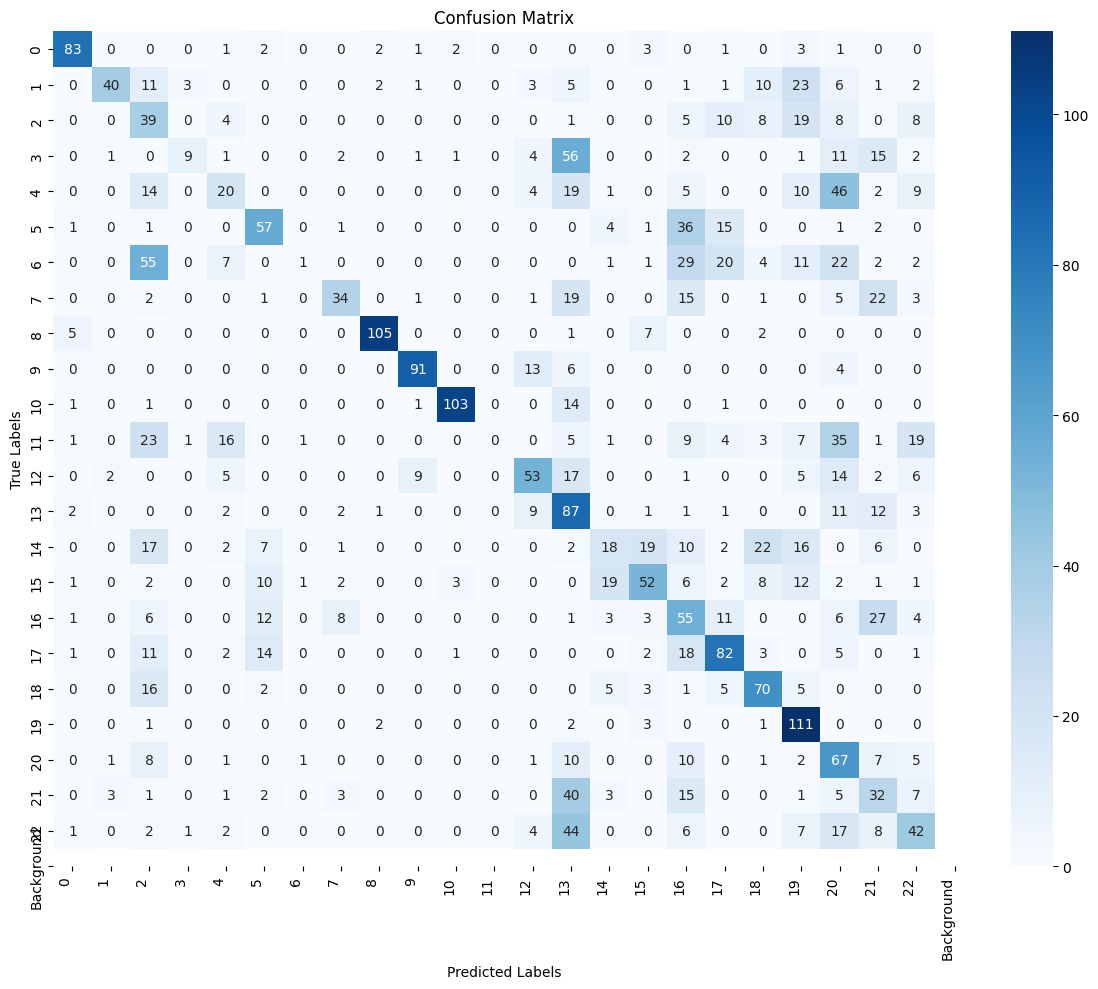

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot a confusion matrix as a heatmap with class names on x and y axes.

    Parameters:
        conf_matrix (numpy array): Confusion matrix to plot.
        class_names (list): List of class names for labeling axes.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Ensure `class_names` and `confusion_mat` are defined
# Replace `dataset.classes` with your actual list of class names
class_names = dataset.classes + ["Background"]  # Example if background class is included
plot_confusion_matrix(confusion_mat, class_names)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(all_labels, all_preds, num_classes):
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    print("Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return acc, recall, precision, f1, conf_matrix


In [ ]:
import torch
from tqdm import tqdm  # Import the tqdm library for progress bar

# Load the trained model weights
model_path = "/content/drive/MyDrive/saved_model_weights.pth"  # Path to saved weights
model.load_state_dict(torch.load(model_path))  # Load the saved weights
model.to(device)  # Ensure the model is on the same device
print("Model weights loaded successfully!")

# Validation function
def validate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation
        progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        for batch_idx, (images, targets) in progress_bar:
            # Move images and targets to the device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Accumulate loss
            val_loss += losses.item()

            # Update progress bar with batch-specific loss
            progress_bar.set_postfix({
                "Batch Loss": f"{losses.item():.4f}",
                "Avg Loss": f"{val_loss / (batch_idx + 1):.4f}"
            })

    # Compute average validation loss
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

# Perform validation
validate_model(model, val_loader, device)
